In [ ]:
########################################
# Keras
########################################
from keras.models import load_model                                                                     # load up models from file
from keras import Model, Input                                                                          # major classes
from keras.layers import Dense, Flatten, Dropout, LeakyReLU, BatchNormalization, Softmax, Embedding     # layers
from keras.losses import categorical_crossentropy, mean_squared_error                                   # cost functions
from keras.optimizers import Adam                                                                       # optimizer
from keras.regularizers import l1, l2                                                                   # regularizers
from keras.initializers import glorot_normal                                                            # for normalization

########################################
# Preparing data
########################################
from sklearn.model_selection import train_test_split # split into training and testing data

# common packages
from multiprocessing import Pool
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np
import pickle

# 1 - Preparing the training data

Neural networks are very simple objects - they take an **1D-array** of inputs, perform a series of matrix multiplication and transformations, and output **1D-array**:

<img src="images_inkscape/basic_in_out.png" style="width: 200px;">

During training, you need to supply a lot of such 1D-arrays (> 10,000). The way `tensorflow` works, means that they must be passed in as an array of `N` stacked vectors:

<img src="images_inkscape/stacked_in_out.png" style="width: 400px;">

## An imporant part is thus preparing such a dataset for integration. 
- <font color=red><b>Each new training element must occupy a single row (input and corresponding output)</b></font>
- <font color=red><b>There must be <code>N</code> such rows for the N training elements</b></font>
***

## Split the input data into <a name="splitting"></a>98% training and 2% testing
<center><font color=red><b>⚠ Do not touch the 2% testing data during training. The whole idea, is for the trained network to classify the testing data that it has never seen.</b></font></center>

<img src="images_inkscape/breaking_training_up.png" style="width: 400px;">

***
*For the time being, do not worry about how this language dataset was encoded - this will be covered in <a href="./material_encodingData_notebook.ipynb" ><b>Input encoding Tutorial<b></a>*

In [3]:
########################################
# 1 - load in the input data
########################################
with open("language_data.pkl", 'rb') as fin:
    data = pickle.load(fin)
X_raw = data['X-input']
Y_raw = data['Y-output']

########################################
# 2 - check the format of the data:
#       110283 elements
#       🔴 each input element is a 2D array 15(characters)x26(each one a-z)  which will eventually have to be flattened
#       🔵 each output element is a 1D array of length 10 (10 different languages)
########################################
print("🔴 Shape of the input:\t", X_raw.shape)
print("🔵 Shape of output:\t", Y_raw.shape)

🔴 Shape of the input:	 (110283, 15, 26)
🔵 Shape of output:	 (110283, 10)


In [4]:
########################################
# 3 - split into training and testing
#   - random state shuffles the inputs
########################################
(X_train, X_test,
 Y_train, Y_test) = train_test_split(X_raw,
                                     Y_raw,
                                     test_size = 0.02, random_state=42, shuffle=True)

# 🔐 Saving data
It is good at this point to save the data, or you might end up training the model on `X_train`  and `Y_train`, and close the program.

Voila - when you reload the file and rerun the train-test split,  there is no gurantee that the new `X_test` and `Y_test` will be the same ones as before (unless you do `shuffle=False`, but that is limiting since you might get a bias due to the order of the elements).

<center>Therefore it is important to save the exact training and testing sets. Dictionaries and `pickle` are great for that.</center>

In [ ]:
########################################
# 4 - save data for future use
########################################
dictionary_to_write = {"X-train": X_train,
                       "X-test": X_test,
                       "Y-train": Y_train,
                       "Y-test": Y_test}
with open("language_data_prepared.pkl", 'wb') as fout:
    pickle.dump(dictionary_to_write)

# 2 - Building simple model
The simple model:
- flattens each 2D input element;
- passes it through a hidden layer of 5 * number_of_input_nodes and applies `sigmoid` <a href="#activation">activation</a> to each one;
- generates an output array of dim (10), which is tries to match to the label array of dim (10).
<img src="images_inkscape/simple_model.png" style="width: 800px;">
*Note, that not all of the nodes are shown*
***
An <a name="activation" ><code>Activation</code></a> applies a linear map to <font color=red>every single node</font> in the intermediate layer (in the case, all of the 5 * number_of_input_nodes).

<img src="images_inkscape/usual_activation.png" style="width: 500px;">

In [22]:
########################################
# 1 - specify the shape of the inputs
#   - if each element was a 1D array then the call would be Input((X_train.shape[1], ))
########################################
INPUTS = Input((X_train.shape[1], X_train.shape[2]))

########################################
# 2 🥞 flatten each element from (15, 26) → (15*26)
#    - this is only required if the elements are not 1D
########################################
number_of_input_nodes = (X_train.shape[1] * X_train.shape[2])
FLATTENED = Reshape((number_of_input_nodes,))(INPUTS)

# 3 - hidden layer with 5 times the input nodes and sigmoid activation. 
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, activation='sigmoid')(FLATTENED)

# 4 - ouput layer is also DENSE. must contain the number of nodes that the ouput has
OUTPUT_LAYER = Dense(Y_train.shape[1])(PROPAGATING_LAYER)

########################################
# 5 - compile the model with the simplest optimizer used in back propagation
########################################
model = Model(inputs=INPUTS, outputs=OUTPUT_LAYER)
model.compile(loss=mean_squared_error, optimizer='sgd')
print(model.summary())

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 15, 26)            0         
_________________________________________________________________
reshape_13 (Reshape)         (None, 390)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1950)              762450    
_________________________________________________________________
dense_25 (Dense)             (None, 10)                19510     
Total params: 781,960
Trainable params: 781,960
Non-trainable params: 0
_________________________________________________________________
None


# 3 - training the model
Once the model is built, the actual training dataset is passed to it.
- `epochs`: Specify number of times retrain on the whole dataset (each time weights will coverge to closer and closer to optimal point)
- `batch_size`: number of samples with which to perform full forward-backward sweep. Refer to <a href="./optimization_report.pdf#10" ><b>Section 5<b></a>

too small a batch, and decent to the optimal point becomes choppy (stochastic descent). Too large, the network training is not reactive enough, with infrequent weight updates.
<img src="images_inkscape/batch_size_for_gradient_descent.png" style="width: 300px;">


- `validation_split`: proportion of samples taken out each sweep to probe the current performance of the network on unseed data - `val_loss`

<center><i>It is a good question to ask - "why even bother with separating out some testing data <a href="#splitting">here</a>, if it is done for us during fitting?"</i></center>
<center><b>Well, you don't control which datapoints are isolated, and only explicitly extracting a portion beforehand can ensure that they are in no way involved in the traning process.</b></center>

<font color=red><b>The model below will not train well - it will be optimized later on in the notebook</b></font>

Train on 106996 samples, validate on 1081 samples
Epoch 1/10
106996/106996 [==============================] - 2s 22us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 2/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 3/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 4/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 5/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 6/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 7/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 8/10
106996/106996 [==============================] - 2s 21us/step - loss: 15.5319 - val_loss: 15.4322
Epoch 9/10
106996/106996 [==============================] - 2s 21us/step - los

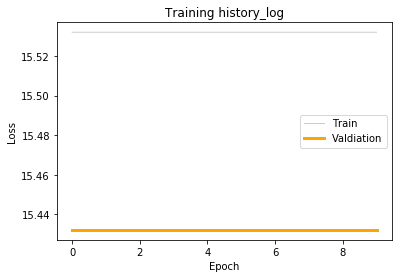

In [29]:
########################################
# 6 - train model on the dataset.
########################################
epochs = 10
history_log = model.fit(X_train, Y_train,
                        verbose=1, epochs=epochs,
                        batch_size=1024, validation_split=0.01)

# 7 - print result
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(history_log.history["loss"], color='grey', linewidth=1, alpha=0.4)
ax.plot(history_log.history["val_loss"], color="orange", linewidth=3)
ax.set_title("Training history_log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(["Train", "Valdiation"])

plt.show()

# 4 - Accuracy imporovements 🏹
The first network gave very poor performance, as shown by the high `loss` and `val_loss`. **Ideally both should be << 1**. 


The following set of improvements will generally improve performance.

## a - Add a second layer
<center><font color=red>Actually, by uncommenting the second layer, you will find that it doesn't bring in a good improvement. Welp, it is a guessing game.</font></center>

***

## b - Add `Batch Normalization` 
- (<a href="./optimization_report.pdf" ><b>Section 4<b></a>);
- To normalize intermediate nodes in the network. In this way weights from earlier layers will not have strong repercussion in later ones, preventing exploding or vanishing values within the network.
<center><font color=red><b>⚠ Beware, that <code>Batch Normalization</code> must happen before activation</b></font></center>

***

## c - Stand-alone activation layer
- `ReLu Activation` is now added as a stand-alone layer after each `Batch normalization`;
- It tends to perform better than `sigmoid` activation;
- Feel free to experiment with <font color=red><a href="https://keras.io/layers/advanced-activations/">more activations</a></font>.

***

## d - Add `Adam` optimizer for backpropagation
- <a href="#adam">It will be looked further in this section</a>

<img src="images_inkscape/simple_model_v2.png" style="width: 1000px;">


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 15, 26)            0         
_________________________________________________________________
flatten_inputs (Flatten)     (None, 390)               0         
_________________________________________________________________
2_dense (Dense)              (None, 1950)              762450    
_________________________________________________________________
2_batch (BatchNormalization) (None, 1950)              7800      
_________________________________________________________________
2_activation (LeakyReLU)     (None, 1950)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                19510     
Total params: 789,760
Trainable params: 785,860
Non-trainable params: 3,900
________________________________________________

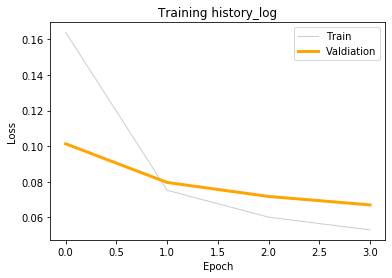

In [7]:
epochs = 4
number_of_input_nodes = (X_train.shape[1] * X_train.shape[2])

INPUTS = Input((X_train.shape[1], X_train.shape[2]))
FLATTENED = Flatten(name="flatten_inputs")(INPUTS)
PROPAGATING_LAYER = BatchNormalization(name="batchNorm_inputs")(FLATTENED)
# layer 1
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, name="1_dense",)(FLATTENED)
PROPAGATING_LAYER = BatchNormalization(name="1_batch")(PROPAGATING_LAYER)
PROPAGATING_LAYER = LeakyReLU(0.1, name='1_activation')(PROPAGATING_LAYER)
# layer 2
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, name="2_dense",)(PROPAGATING_LAYER)
PROPAGATING_LAYER = BatchNormalization(name="2_batch")(PROPAGATING_LAYER)
PROPAGATING_LAYER = LeakyReLU(0.1, name='2_activation')(PROPAGATING_LAYER)
OUTPUT_LAYER = Dense(Y_train.shape[1])(PROPAGATING_LAYER)

########################################
# 5 - compile the model 
########################################
model = Model(inputs=INPUTS, outputs=OUTPUT_LAYER)
model.compile(loss=mean_squared_error, optimizer='adam')
print(model.summary())

########################################
# 6 - train model on the dataset.
########################################
history_log = model.fit(X_train, Y_train,
                        verbose=1, epochs=epochs,
                        batch_size=1024, validation_split=0.01)

# 7 - print result
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(history_log.history["loss"], color='grey', linewidth=1, alpha=0.4)
ax.plot(history_log.history["val_loss"], color="orange", linewidth=3)
ax.set_title("Training history_log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(["Train", "Valdiation"])

plt.show()

# 5 - saving and testing the model
- Once a model is trained, it tested on the **test** part of the dataset, which so far has not been touched by any training.

- Prior to this make sure to save the network with all of the metadata, using good old dictionaries 📕.

In [42]:
def save_nn(model, metadata, data, save_name, save_folder="trained_nn"):
    """
    __ Parameters __
    [ks.model] model:           to save
    [dictionary] metadata:      dictionary with the metadata on the nn
    [dictionary] data:          train and test data
    [str] save_name:            name to save nn under
    [str] save_folder:          folder where to save nn

    __ Description __
    Save the model and its metadata for future use
    """
    # 1 - create folder to store the nn
    if not os.path.exists(f"./{save_folder}"):
        os.makedirs(save_folder)
    # 2 - save the model
    model.save(f"{save_folder}/{save_name}.nn")
    # 3 - save metadata of the model
    with open(f"{save_folder}/{save_name}_metadata.pkl", 'wb') as fout:
        pickle.dump(metadata, fout)
    # 4 - save training and testing data
    with open(f"{save_folder}/{save_name}_data.pkl", 'wb') as fout:
        pickle.dump(data, fout)
        
        
def load_nn(save_name, save_folder="trained_nn"):
    """
    __ Parameters __
    [str] save_name:            name the nn was saved under
    [str] save_folder:          folder nn is in

    __ Description __
    Load the model and metadata

    __ Returns __
    [model] with the initialized weights from the file
    [dictionary] metadata on the model
    """

    # 1 - load the model
    model = load_model(f"./{save_folder}/{save_name}.nn")
    # 2 - load the metadata
    with open(f'{save_folder}/{save_name}_metadata.pkl', 'rb') as fin:
        metadata = pickle.load(fin)
    # 3 - load training and testing data
    with open(f'{save_folder}/{save_name}_data.pkl', 'rb') as fin:
        data = pickle.load(fin)
        
    return model, metadata, data


########################################
# 1 - generate a list of metadata for the model
########################################
metadata = {"X-train_dim": X_train.shape,
            "Y-train_dim": Y_train.shape,
            # anything else which would be required to recreate the model
}
train_test_data = {"X-train": X_train,
                       "X-test": X_test,
                       "Y-train": Y_train,
                       "Y-test": Y_test}
########################################
# 2 - save
########################################
save_nn(model, metadata, train_test_data, "language_v1")

In [50]:
########################################
# 3 ⏰  imagine some time has passed, or testing is perfromed on a different computer
########################################
model, metadata, data = load_nn("language_v1")

X_test = data['X-test']
Y_test = data['Y-test']

# 1 - run prediction
prediction = model.predict(X_test)

########################################
# 2 -  find how many of the predictions were correct
########################################
prediction_mostLikely = np.argmax(prediction, axis=1)
error_array = np.argmax(Y_test, axis=1) - prediction_mostLikely
error_indicies = np.nonzero(error_array)[0]

print(f"⦿  {len(error_indicies) / len(X_test) * 100:.2f}% error - {len(error_indicies)}/{len(X_test)} samples")

⦿  37.40% error - 825/2206 samples


# 6 - Combating overtraining ⚔
To prevent overtraining of the network, `regularization` and `dropout` can be applied (<a href="./optimization_report.pdf">Section 2</a>).
***
## a - Regularizers
- During backpropagation all weights undergo an additional supression - <font color=red>With moderated weights, the model will not be able to overfit to the training set</font>;
- `regularizers` need to be called as parameters in the layers tha have tuneable weights e.g. `Dense(69, kernel_regularizer=ks.regularizers.l1(lambd))`;
- `L2 regularization` is more aggressive than `L1 regularization`;
- `lambda` controls the strength of regularization;
- keeping weights small, effectively blocks flow of information (multiplication by a very small number), which limits the size of the network.
<img src="images_inkscape/overfitting_set_to_0_png.png" style="width: 200px;">

***

## b - Dropout
- Every epoch, certain neurons are randomly shut down from this layer:
 <center><font color=red>Each iteration of the NN trains a different model that uses only a subset of the neurons. The model needs to diversify over all the available neurons, and less likely to have preference on a persistent subset.</font></center>
- It is a placed <font color=red><b>before</b></font> a layer to prevent it from receiving a portion of the inputs;
- `Dropout(dropout_rate)(PROPAGATING_LAYER)`
- `rate` sets the proportion of neurons that are shut down each epoch.
<img src="images_inkscape/dropout.png" style="width: 400px;">

***

## c - Other ways
- Take inputs and distort them: rotate, flip, offset; 
- Stopp before overfitting begins to occur by closely monitoring the `loss` and `val_loss` values.

# 7 - Improving efficiency of training
1. Initialize the weights of the hidden layers according to some distribution: `normal`, `glorot_normal` (<a href="./optimization_report.pdf" ><b>Section 3<b></a>);
<center><font color=red>If using <code>glorot_normal</code> initialization, activate using <code>Leaky ReLu</code></font></center>

***

2. Specify the parameters of the optimizer that is being used: <a name="adam"></a>
<img src="images_inkscape/gradient_descent_average.png" style="width: 250px;">

The optimizer the algorithm by which weights are updated during back propagation. It has a very neat mathematical background, which is covered in  <a href="./optimization_report.pdf" ><b>Section 6<b></a>. Choosing a good optimizer can result in a smotther descent to the local minimum of the cost function. 

- `ɑ`: controls speed of descent;
- `β1 ~ 0.9` controls averaging over the past history of the gradient. The gradient is used to update the weight, and taking an average supresses sideways oscillations;
- `β2 ~ 0.99` controls averaging over the past history of the gradient's variance'. The variance is similarly used to supresses sideways oscillations.


<a href="https://keras.io/optimizers/">Other optimizers can also be considered</a>

In [11]:
epochs = 4
lambd = 0.03
dropout_rate = 0.3

number_of_input_nodes = (X_train.shape[1] * X_train.shape[2])
INPUTS = Input((X_train.shape[1], X_train.shape[2]))
FLATTENED = Flatten(name="flatten_inputs")(INPUTS)
PROPAGATING_LAYER = BatchNormalization(name="batchNorm_inputs")(FLATTENED)
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, name="1_dense",
                          kernel_initializer=glorot_normal(seed=random.randint(1, 10000)),
                          kernel_regularizer=l2(lambd))(PROPAGATING_LAYER)
PROPAGATING_LAYER = Dropout(dropout_rate, name="1_dropout")(PROPAGATING_LAYER)
PROPAGATING_LAYER = BatchNormalization(name="1_batch")(PROPAGATING_LAYER)
PROPAGATING_LAYER = LeakyReLU(0.1, name='1_activation')(PROPAGATING_LAYER)
PROPAGATING_LAYER = Dense(5 * number_of_input_nodes, name="2_dense",
                          kernel_initializer=glorot_normal(seed=random.randint(1, 10000)),
                          kernel_regularizer=l2(lambd))(PROPAGATING_LAYER)
PROPAGATING_LAYER = BatchNormalization(name="2_batch")(PROPAGATING_LAYER)
PROPAGATING_LAYER = LeakyReLU(0.1, name='2_activation')(PROPAGATING_LAYER)
OUTPUT_LAYER = Dense(Y_train.shape[1])(PROPAGATING_LAYER)

########################################
# 5 - compile the model 
########################################
learning_rate = 0.0001
beta_1 = 0.85
beta_2 = 0.99
adam_tuned = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2)           # 🐋🐋🐋 custom now
model = Model(inputs=INPUTS, outputs=OUTPUT_LAYER)
model.compile(loss=mean_squared_error, optimizer=adam_tuned)
print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 15, 26)            0         
_________________________________________________________________
flatten_inputs (Flatten)     (None, 390)               0         
_________________________________________________________________
batchNorm_inputs (BatchNorma (None, 390)               1560      
_________________________________________________________________
1_dense (Dense)              (None, 1950)              762450    
_________________________________________________________________
1_dropout (Dropout)          (None, 1950)              0         
_________________________________________________________________
1_batch (BatchNormalization) (None, 1950)              7800      
_________________________________________________________________
1_activation (LeakyReLU)     (None, 1950)              0   

Train on 106996 samples, validate on 1081 samples
Epoch 1/4
106996/106996 [==============================] - 23s 212us/step - loss: 57.8263 - val_loss: 39.8899
Epoch 2/4
106996/106996 [==============================] - 22s 206us/step - loss: 28.6873 - val_loss: 19.1741
Epoch 3/4
106996/106996 [==============================] - 22s 207us/step - loss: 13.4139 - val_loss: 8.5812
Epoch 4/4
106996/106996 [==============================] - 23s 211us/step - loss: 5.7685 - val_loss: 3.4616


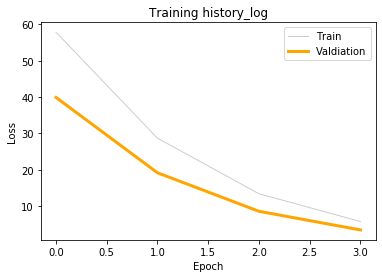

In [12]:
########################################
# 6 - train model on the dataset.
########################################
history_log = model.fit(X_train, Y_train,
                        verbose=1, epochs=epochs,
                        batch_size=1024, validation_split=0.01)

# 7 - print result
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(history_log.history["loss"], color='grey', linewidth=1, alpha=0.4)
ax.plot(history_log.history["val_loss"], color="orange", linewidth=3)
ax.set_title("Training history_log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(["Train", "Valdiation"])

plt.show()

<font color=red size="1.4"><a href="./material_buildingNN_notebook_EXAMPLE.ipynb"><b>Click here to see a full worflow</b></a></font>